# Purpose:

I want to use the cluster calls to estimate the strength of size distortion given the size of clusters with a given genotype. For example, if I see that there is are many more cells be sampled from a particular individual with a particular genotype consistently then that would be a sign for size distortion. How exactly to model that I need to work out, but I can at least play around with some of this data.

In [6]:
import csv
import pandas as pd
import numpy as np
import os
import numpy as np
import operator
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
from sklearn.cluster import AgglomerativeClustering
import argparse
from multiprocessing import Pool
import random
from scipy.optimize import curve_fit
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
import importlib.util
import itertools
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.metrics import log_loss
import functools
from scipy.stats import chi2

spec = importlib.util.spec_from_file_location("sciAnalysis", "/home/iskander/Documents/Barbash_lab/mDrive/sciAnalysis.py")
sciAnalysis = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sciAnalysis)

def extrStates(states):
    #I am attempting to conform the reading of these known labels to the way that I have produced the HMM labels
    #within sciAnalysis so I can re-use code....
    state_tuples = []
    if len(states) > 1:
        for s in range(len(states)-1):
            state_tuples.append((states[s], states[s+1]))
    else:
        state_tuples.append(states[0])
    
    return state_tuples

def readCO(tsv, path):
    #Record only the individuals that are unique the sampling to get the true AF
    COs = []
    labels = []
    add_Mb = {'2L': 0, '2R': 23000000, '3L': 0, '3R': 24500000, 'X': 0}
    full_tsv = os.path.join(path, tsv)
    with open(full_tsv, 'r') as myTsv:
        TSV_reader = csv.reader(myTsv, delimiter='\t')

        index = 0
        for field in TSV_reader:
            #each individual will have an array of their breakpoints and their chromosome states
            chr2 = [int(pos)/1000000 for pos in field[2].split(',') if pos != ''] + [(int(pos) + add_Mb['2R'])/1000000 for pos in field[5].split(',') if pos != '']
            chr2_states = [int(segment) for segment in field[3].split(',')][:-1] + [int(segment) for segment in field[6].split(',')]
            refChr2 = extrStates(states=chr2_states)
            
            chr3 = [int(pos)/1000000 for pos in field[8].split(',') if pos != ''] + [(int(pos) + add_Mb['3R'] )/1000000for pos in field[11].split(',') if pos != '']
            chr3_states = [int(segment) for segment in field[9].split(',')][:-1] + [int(segment) for segment in field[12].split(',')]
            refChr3 = extrStates(states= chr3_states)
            
            chrx = [int(pos)/1000000 for pos in field[14].split(',') if pos != '']
            chrx_states = [int(segment) for segment in field[15].split(',')]
            refChrx = extrStates(states=chrx_states)
            
            all_labels = [refChr2, refChr3, refChrx]
            all_COS = [chr2, chr3, chrx]
            COs.append(all_COS)
            labels.append(all_labels)
            
            index += 1
            
    return COs, labels

def sciAnalysis_methods(CO_data, state_labels, numpy):
    myAnalysis = sciAnalysis.analyzeSEQ()
    myAnalysis.polarized_samples = myAnalysis.load_SNP_array(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/',
                                                            snp_array=numpy, encoding='latin1')
    myAnalysis.paintedGenome = [np.concatenate((myAnalysis.polarized_samples[0][0][:, 0], myAnalysis.polarized_samples[0][1][:, 0] + 23000000)) / 1000000,
                                np.concatenate((myAnalysis.polarized_samples[0][2][:, 0], myAnalysis.polarized_samples[0][3][:, 0] + 24500000)) / 1000000,
                                myAnalysis.polarized_samples[0][4][:, 0] / 1000000]
    
    myAnalysis.rmap = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/dmel_2xRate.rmap.bed', sep='\t', header=None)
    
    
    SNP_pileup = []
    for sample in range(len(state_labels)):
        
        SNPs = myAnalysis.paintChromosome(breakpoints=CO_data[sample], labels=state_labels[sample])
        SNP_pileup.append(SNPs)
    
    for arm in range(3):
        myAnalysis.paintedGenome[arm] = np.vstack((myAnalysis.paintedGenome[arm], np.sum(np.vstack(np.vstack(SNP_pileup)[:,arm]), axis=0) / (2*len(state_labels)))).T
    
    #Compute SD params
    params, errs, AFs = myAnalysis.estimateSD_params(myAnalysis.paintedGenome)
    
    
    #Do the plotting
    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(12,5))
        sns.scatterplot(myAnalysis.paintedGenome[1][:,0], myAnalysis.paintedGenome[1][:,1],edgecolor=None, alpha=.1, color='black')
        plt.plot(AFs[1][:,0], AFs[1][:,1], linestyle='--', color='blue')
        plt.title('Chr3 theoretical pseudobulk')
        plt.xlabel('Mb')
        plt.ylabel('P2 AF')
        plt.show()
        plt.close()

    print('Driver strength: {0:.2f}%'.format(params[1][0]*100))
    

## 2x recomb. rate data:

I want to use the virillis recombination rate data here as it is doing the best job at being clustered and so I can at least try to solve this "easy" problem before I try my hand at the melanogaster problem. So I'm going to load in the posteriors to do clustering on it first.

In [7]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_2x_rate__HMM_posteriors.npy')

cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)
        #cluster_pred = DBSCAN(eps=distance, min_samples=1, n_jobs=threads).fit(opt_embed).labels_

        #### Get all cluster predictions and cells into a table:
all_clusters = {}
for cell in range(len(cluster_pred)):
        if cluster_pred[cell] not in all_clusters.keys():
            all_clusters[cluster_pred[cell]] = [cell]
        else:
            all_clusters[cluster_pred[cell]].append(cell)


FileNotFoundError: [Errno 2] No such file or directory: '/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_2x_rate__HMM_posteriors.npy'

In [8]:
#get all clusters that more than one individual:
mergeable_clusters = [all_clusters[mc] for mc in all_clusters.keys() if len(all_clusters[mc]) > 1]
all_inds = list(itertools.chain.from_iterable(mergeable_clusters))

NameError: name 'all_clusters' is not defined

In [ ]:
#As a vage attempt I'm going to compute the average posterior probability along the chromosome
#If size distortion is driving this then there should be a strong signal within these individuals
avg_pos = np.average(posteriors[all_inds], axis=0)

plt.plot(avg_pos)
plt.show()
plt.close()

The problem with this is that it's hard to tell exactly what this is telling me and which arm is what. Yes there are spikes in the P1 homozygote probability. To make real sense of this I may just have to compute the allele frequency. I could use viterbi decoding to try and do it after I impute genotypes which would likely give me pretty solid results. To test this out I'm going to use the known labels and AFs of these cluster calls first to see what signal I would get and if it would be more interpretable than this.

### Big clusters:

In [ ]:
COs, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/' , tsv='2x_rate_.2xSize_crossovers.tsv')

CO_called = []
labels_called = []
for i in all_inds:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called)

In this we can clearly see a very strong signal here of "drive" in just the individuals that are clustered. But what happens if we look at collapsed clusters?

### Collapsed clusters:

In [ ]:
collapsed_clusters = [np.random.choice(all_clusters[c]) for c in all_clusters.keys()]
COs, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/' , tsv='2x_rate_.2xSize_crossovers.tsv')

CO_called = []
labels_called = []
for i in collapsed_clusters:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called)

In collapsed clusters the signal is weaker but still present. I wonder if there is something with the ratio of these two drive estimates that could get me to the answer I seek.

## No size distortion -- 10% segregation distortion:

I'm going to continue testing out what the data may look like if I have no size distortion, but have segregation distortion.

In [ ]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_2x_SegD_HMM_posteriors.npy')

cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)

        #### Get all cluster predictions and cells into a table:
all_clusters = {}
for cell in range(len(cluster_pred)):
        if cluster_pred[cell] not in all_clusters.keys():
            all_clusters[cluster_pred[cell]] = [cell]
        else:
            all_clusters[cluster_pred[cell]].append(cell)


### Only big clusters:

In [ ]:
#get all clusters that more than one individual:
mergeable_clusters = [all_clusters[mc] for mc in all_clusters.keys() if len(all_clusters[mc]) > 1]
all_inds = list(itertools.chain.from_iterable(mergeable_clusters))

COs, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/' , tsv='2x_SegD_crossovers.tsv')

CO_called = []
labels_called = []
for i in all_inds:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called)

### Collapsed clusters

In [ ]:
collapsed_clusters = [np.random.choice(all_clusters[c]) for c in all_clusters.keys()]
COs, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/' , tsv='2x_SegD_crossovers.tsv')

CO_called = []
labels_called = []
for i in collapsed_clusters:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called)

An observation that I see is that when there is Seg distortion the collapsed clusters and the "big" clusters have similar estimates of distortion. 

## Seg & Size distortion (10%):



In [ ]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_2x_seg+size_HMM_posteriors.npy')

cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)

        #### Get all cluster predictions and cells into a table:
all_clusters = {}
for cell in range(len(cluster_pred)):
        if cluster_pred[cell] not in all_clusters.keys():
            all_clusters[cluster_pred[cell]] = [cell]
        else:
            all_clusters[cluster_pred[cell]].append(cell)


### Big clusters

In [ ]:
#get all clusters that more than one individual:
mergeable_clusters = [all_clusters[mc] for mc in all_clusters.keys() if len(all_clusters[mc]) > 1]
all_inds = list(itertools.chain.from_iterable(mergeable_clusters))

COs, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/' , tsv='2x_seg+size_crossovers.tsv')

CO_called = []
labels_called = []
for i in all_inds:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called)

### Collapsed clusters:

In [ ]:
collapsed_clusters = [np.random.choice(all_clusters[c]) for c in all_clusters.keys()]
COs, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/' , tsv='2x_seg+size_crossovers.tsv')

CO_called = []
labels_called = []
for i in collapsed_clusters:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called)

In [ ]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_newtest_HMM_posteriors.npy')

cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)

        #### Get all cluster predictions and cells into a table:
all_clusters = {}
for cell in range(len(cluster_pred)):
        if cluster_pred[cell] not in all_clusters.keys():
            all_clusters[cluster_pred[cell]] = [cell]
        else:
            all_clusters[cluster_pred[cell]].append(cell)
            
#get all clusters that more than one individual:
mergeable_clusters = [all_clusters[mc] for mc in all_clusters.keys() if len(all_clusters[mc]) > 1]
all_inds = list(itertools.chain.from_iterable(mergeable_clusters))

COs, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/' , tsv='newtest_crossovers.tsv')

CO_called = []
labels_called = []
for i in all_inds:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called)

collapsed_clusters = [np.random.choice(all_clusters[c]) for c in all_clusters.keys()]
COs, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/' , tsv='newtest_crossovers.tsv')

CO_called = []
labels_called = []
for i in collapsed_clusters:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called)

## Subtract size distortion parameter from segregation distorter parameter:

I have a thought to subtract size distortion from the segregation distortion parameter. Given these three examples we can see the following cases: When there is no segregation distortion, but there is size distortion then the large over represented clusters will have a big distortion estimate compared to the merged clusters e.g. 15% vs 5%. In the segregation distortion, but no size distortion then both classes have roughly equal distortion estimates e.g. 12% and 10%. In the case of both segregation and size distortion the big cluster class has a higher distortion parameter than the merged clusters class by quite a large margin e.g. 25% vs. 15%. 

My thought is to construct a ratio of these two things so SEG/SIZE and multiply it by SEG. This could in theory work... and intuitively it kind of makes sense. However, it's a little bit heuristic and not very principled. I think there is a more statistical way of doing this, but I'm not sure what it is. 

In essence what I am doing is comparing two estimators and trying to determine whether the distributions that they came from are different. I could use something an LRT to try and get the answer to this question. However, once I have t

SNP input loaded... 2098 cells read in...
Fitting parameters for segregation distortion inference...


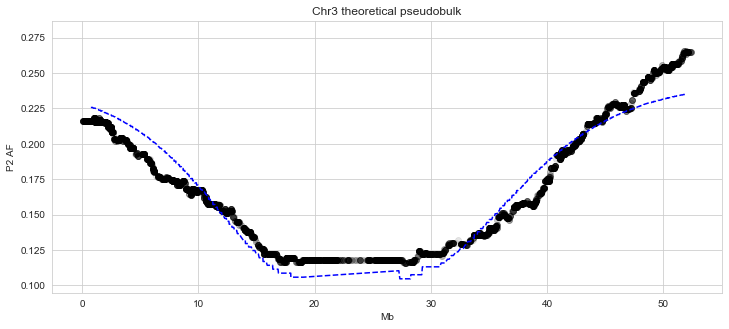

Driver strength: 30.45%
SNP input loaded... 2098 cells read in...
Fitting parameters for segregation distortion inference...


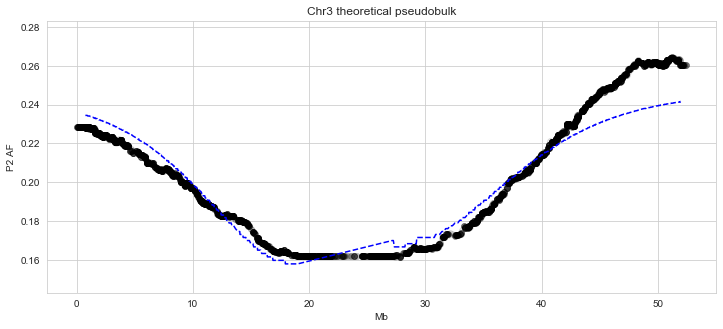

Driver strength: 18.41%
SNP input loaded... 2098 cells read in...
Fitting parameters for segregation distortion inference...


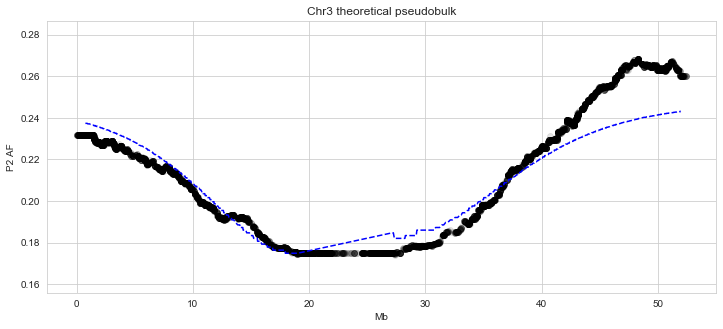

Driver strength: 15.02%


In [3]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_SZ_50_SD_10_HMM_posteriors.npy')


cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)
#### Get all cluster predictions and cells into a table:
all_clusters = {}
for cell in range(len(cluster_pred)):
        if cluster_pred[cell] not in all_clusters.keys():
            all_clusters[cluster_pred[cell]] = [cell]
        else:
            all_clusters[cluster_pred[cell]].append(cell)
            

            
            
#get all clusters that more than one individual:
mergeable_clusters = [all_clusters[mc] for mc in all_clusters.keys() if len(all_clusters[mc]) > 1]
all_inds = list(itertools.chain.from_iterable(mergeable_clusters))

COs, labels = readCO(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/' , tsv='SZ_50_SD_10_crossovers.tsv')

CO_called = []
labels_called = []
for i in all_inds:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called, numpy='SPARSE_SZ_50_SD_10.npy')

#Drive parameter of one individual per cluster
collapsed_clusters = [np.random.choice(all_clusters[c]) for c in all_clusters.keys()]
CO_called = []
labels_called = []
for i in collapsed_clusters:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called, numpy='SPARSE_SZ_50_SD_10.npy')

#Get drive parameter of the individuals that are not in dense clusters
noise_clusters = [all_clusters[mc] for mc in all_clusters.keys() if len(all_clusters[mc]) == 1]
noisy_inds = list(itertools.chain.from_iterable(noise_clusters))
CO_called = []
labels_called = []
for i in noisy_inds:
    CO_called.append(COs[i])
    labels_called.append(labels[i])

sciAnalysis_methods(CO_data=CO_called, state_labels=labels_called, numpy='SPARSE_SZ_50_SD_10.npy')

## Conclusions:

I have tested using the ratio of the strengths from the two groups and it doesn't really seem to work. It also doesn't really have a very rigorous logic behind it. I think I will consider this approach a failure and move on to a different approach.

# Modelling size distortion:

The only real way to get at this problem is to infer the strength of the size distortion by modelling the distribution where this individual was generated from. There are two Normal distributions by which we sample our individuals from. In the case of size distortion there is a shift in the mean of the distributions which bias the sampling from larger individuals with a particular genotype. This should manifest as an over representation of clustering and should differ from when the two distributions are the same. 

In [12]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_SZ_10_SD_0_HMM_posteriors.npy')


cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)

        #### Get all cluster predictions and cells into a table:
all_clusters = {}
for cell in range(len(cluster_pred)):
        if cluster_pred[cell] not in all_clusters.keys():
            all_clusters[cluster_pred[cell]] = [cell]
        else:
            all_clusters[cluster_pred[cell]].append(cell)
            

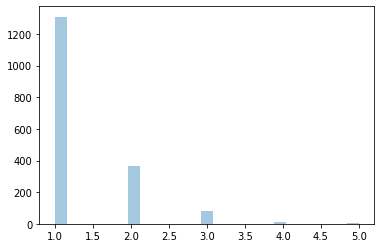

In [13]:
cluster_density = np.asarray([len(c) for c in all_clusters.values()])

sns.distplot(cluster_density, kde=False)
plt.show()
plt.close()

Here I have loaded the posterior probabilities for a HMM run where there is 0 SD, but 10% SZ (seg distortion size distortion). I am displaying the dsitribution of the size of clusters. In these cases there should be a slight over representation of clusters. This is because there is an increase in bias for sampling the same individual and also for sampling certain genotypes. This should also manifest as a deviation from the expected number of unique individuals given our sampling:

$E = (N * (1-((N-1) / N)^k))/k$

Where N is the number of flies and k is the number of cells sequenced. So since we have the total number of cells and the know the input number of flies we could try to approximate our expected proportions of unique cells.

In [14]:
total_indivs = 4000
total_cells = len(cluster_density)
expect = (total_indivs * (1- ((total_indivs-1) / total_indivs)**total_cells)) / total_cells
print(expect)

0.8080582642356375


So we expect 80% of the cells to be unique if we are sampling completely uniformly. Now what does our empirical data look like?

In [15]:
empirical_unique = len(np.where(cluster_density == 1)[0]) / len(cluster_density)
print(empirical_unique)

0.7391304347826086


We can see there is a reduction in the number of unique clusters. We must remember that our actual sampling process is not completely uniform. There are two distinct distributions that are being sampled from. Perhaps if I take the individuals who are of genotype P1 and genotype P2 and calculate the differences in their unique-ness I can use this to infer the differences in the two distributions. If I can model the relationship between the expected proportion then I could use a Bayesian approach to estimate the parameters. There ought to be a difference between the number of unique individuals that are P1 and are P2 at the centromere such that the P1 SZ locus has less uniqueness.

In [16]:
CO_df = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SZ_10_SD_0_crossovers.tsv', sep='\t', header=None)

In [17]:
chr3 = CO_df.values[:,9]
centromere = lambda x: int(x.split(',')[len(x.split(','))-1])
parental_states = np.asarray(list(map(centromere, chr3)))

In [18]:
print(parental_states)

[1 0 0 ... 1 0 0]


Using the labelled data from the simulator I have retrieved the identities of the parental status at the centromere for all individuals. Now I need to seperate the data into clusters for each set of P1 or P2 labels. Then I can see how many non-unique cells there are for P1 and P2 containing cells.

In [19]:
P1_clusters = cluster_pred[np.where(parental_states == 0)]
P2_clusters = cluster_pred[np.where(parental_states == 1)]

In [20]:
def tabulate_clusters(clusters):
    #Turn a np array of cluster labels into a table that contains the IDs of the cells in each cluster
    table = {}
    for cell in range(len(clusters)):
            if clusters[cell] not in table.keys():
                table[clusters[cell]] = [cell]
            else:
                table[clusters[cell]].append(cell)
   
    cluster_density = np.asarray([len(c) for c in table.values()]) #compute a 1d array of the size of each cluster
    
    #compute the number of clusters that have only 1 individual:
    unique = len(np.where(cluster_density == 1)[0]) / len(cluster_density)
    
    return unique

def labels(dataframe, cluster_pred, chromosome=1):
    CO_df = pd.read_csv(dataframe, sep='\t', header=None)
    
    chrom_arm = [3,9,15]
    chr3 = CO_df.values[:,chrom_arm[chromosome]]
    centromere = lambda x: int(x.split(',')[len(x.split(','))-1])
    parental_states = np.asarray(list(map(centromere, chr3)))
    
    P1_clusters = cluster_pred[np.where(parental_states == 0)]
    P2_clusters = cluster_pred[np.where(parental_states == 1)]
    
    return P1_clusters, P2_clusters    

In [21]:
P1 = tabulate_clusters(P1_clusters)
P2 = tabulate_clusters(P2_clusters)

In [22]:
print(P1, P2)

0.714765100671141 0.7639680729760547


Okay so as we can clearly see the P2 clusters are much closer to the expectation of .8 than the P1 clusters. Now let's see what happens in situations where there is no size distortion.

In [23]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_SZ_0_SD_10_HMM_posteriors.npy')
cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)

In [24]:
for ch in range(3):
    P1, P2 = labels(chromosome=ch, dataframe='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SZ_0_SD_10_crossovers.tsv')
    P1_uniq = tabulate_clusters(P1)
    P2_uniq = tabulate_clusters(P2)
    all_uniq = tabulate_clusters(cluster_pred)
    chroms = ['2', '3', 'X']
    print('Chromosome:{0}'.format(chroms[ch]))
    print(P1_uniq, P2_uniq, all_uniq)

TypeError: labels() missing 1 required positional argument: 'cluster_pred'

When there is no size distortion there is not as a stark as a difference and the difference I do see could be due to just noise. Now I'd like to see when I have large differences in SZ (50%) so I can look at the edge cases.

In [ ]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_SZ_50_SD_10_HMM_posteriors.npy')
cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)

In [ ]:
for ch in range(3):
    P1, P2 = labels(chromosome=ch, dataframe='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SZ_50_SD_10_crossovers.tsv')
    P1_uniq = tabulate_clusters(P1)
    P2_uniq = tabulate_clusters(P2)
    all_uniq = tabulate_clusters(cluster_pred)
    chroms = ['2', '3', 'X']
    print('Chromosome:{0}'.format(chroms[ch]))
    print(P1_uniq, P2_uniq, all_uniq)

The outcome seems to be that the stronger the SZ the starker the difference between the proportion of unique cells of P1 and P2 labelled centromere. And the signal is very much strongly seen on chromosome 3 where the SZ locus is. 

In [ ]:
posteriors = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_SZ_10_SD_0_HMM_posteriors.npy')
cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)

for ch in range(3):
    P1, P2 = labels(chromosome=ch, dataframe='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SZ_10_SD_0_crossovers.tsv')
    P1_uniq = tabulate_clusters(P1)
    P2_uniq = tabulate_clusters(P2)
    all_uniq = tabulate_clusters(cluster_pred)
    chroms = ['2', '3', 'X']
    print('Chromosome:{0}'.format(chroms[ch]))
    print(P1_uniq, P2_uniq, all_uniq)

Looking at the entire genome when the SZ is 10 and there is no SD we can see that on Chr3 there is this signal of non-uniqueness, but the signal is not super clean honestly. I think there may be some issues here with the fact that sampling of the chromosomes is not completely independent. If the individuals with Chr3 P1 are oversampled then whatever chromosome that is linked to them will also be oversampled. And although the probability of having any of the chromosomes would be equal due to the limitted sampling their will be some variance there. I think I ought to be able to get around this by perhaps dividing them in genotypic classes.


I have figured out that the model by which cells are sampled from the homegonate is a mutinomial where each $\pi_i$ is proportional to the body size of the individual so our model for the sampling process is:

$MultiN \sim (\pi_i)$ 

Where each $\pi_i$ is draw from a normal distribution dependent on the genotype. I think if we estimate the parameters of our multinomial from our clustering info then we might be able to derive the two normal distributions that the genotypes are drawn from. The maximum likelihood estimator for the multinomial is simply:

$\hat{\pi_i} = \frac{p_i}{N} $, where $p_i$ is the number of times an individual is seen in our sample and $N$ is the sample size. Perhaps it would be better to use Bayesian approaches here, but I'd have to think about my priors and that's a lot of work.

In [ ]:
#ML estimation of our pi_i's:

def est_param(cluster_pred):
    multiN_params = np.zeros(shape=(max(cluster_pred)+1))
    
    for e in cluster_pred:
        
        multiN_params[e] += 1
    multiN_params = multiN_params / np.sum(multiN_params)
    
    return multiN_params

#pi_params = est_param(cluster_pred)    

def get_cluster_sizes(cluster_pred):
    
    c = Counter(cluster_pred)
    sizes = np.asarray(list(c.values()))

    
    return sizes

In [ ]:
def plot_pi(pi_params):
    pi_table = Counter(pi_params)
    pi, counts = zip(*pi_table.items())
    pi = np.asarray(pi)
    counts = np.asarray(counts)
    normed_counts = counts / np.sum(counts)
    sns.barplot(pi.round(decimals=5), normed_counts)
    #plt.xticks(rotation=45)
    plt.title('Cluster size distributions')
    plt.xlabel('Cluster size')
    plt.ylabel('Density')
    plt.show()
    plt.close()



In [ ]:
plot_pi(pi_params)

Once we plot out the categories of each $\hat{\pi}$ estimator we can see the distribution of the cluster sizes reflected in the estimator distributions. The cluster with one individual are in the highest density with a $\hat{\pi} \sim0.00043$, and the larger cluster sizes have higher probabilities. I suspect that if I were to break up this array into the P1 and P2 classes for the chromosome 3 centromere I would see that the P1 SZ cells will have a proportionally fatter tail than the P2 cells. Rather than estimating the parameters it is equivalent for us to simply compute the counts of cluster size.

In [ ]:
#Get chr3 labels:
P1, P2 = labels(chromosome=1, dataframe='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SZ_10_SD_0_crossovers.tsv')
#P1 cluster sizes
P1_pi = get_cluster_sizes(P1)
plot_pi(P1_pi)

#P2 cluster sizes:
P2_pi = get_cluster_sizes(P2)
plot_pi(P2_pi)

So this is less strong as I'd have hoped. I was really expecting a a stronger truncation or reduction in the tail. There does seem to be some difference, though. Perhaps this would be enough to get infer the size parameters.

# Predicting size dependent genotypes through logistic regression:

I had an idea that I could use a logistic regression on all genotypes to find loci that are linked to increased size. This would work similar to a GWAS or QTL analysis, but the phenotype being inferred here would be the cluster size of the individuals. A problem I can forsee with this is that the phenotypes will be skewed heavily toward clusters of 1, with some tails. This may make detecting causative loci difficult, but It's worth a shot honestly. If this works it can be used to detect loci that are linked to increased cluster size which would be a proxy for size differences. 

The classes in the multinomial regression are values between 1, and max(cluster_size). The result of this analysis should be a number of genotypes that are predicted to be associated with increased cluster size. So for this analysis we ought to analyze each genotype which can take two classes:

P1/P1 or P1/P2 - P1, or P2 for short. We can do a simple 0 and 1 encoding for this and perform a GWAS-like analysis. We can use our labelled data set to ensure we would be getting the correct result in a perfect information scenario and then we'll implement it with the Viterbi decoding.

In [25]:
def getSNP_Vector(CO_data, state_labels, numpy):
    myAnalysis = sciAnalysis.analyzeSEQ()
    myAnalysis.polarized_samples = myAnalysis.load_SNP_array(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/',
                                                            snp_array=numpy, encoding='latin1')
    myAnalysis.paintedGenome = [np.concatenate((myAnalysis.polarized_samples[0][0][:, 0], myAnalysis.polarized_samples[0][1][:, 0] + 23000000)) / 1000000,
                                np.concatenate((myAnalysis.polarized_samples[0][2][:, 0], myAnalysis.polarized_samples[0][3][:, 0] + 24500000)) / 1000000,
                                myAnalysis.polarized_samples[0][4][:, 0] / 1000000]
    
    myAnalysis.rmap = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/dmel_2xRate.rmap.bed', sep='\t', header=None)
    
    
    SNP_pileup = []
    for sample in range(len(state_labels)):
        
        SNPs = myAnalysis.paintChromosome(breakpoints=CO_data[sample], labels=state_labels[sample])
        SNP_pileup.append(SNPs)
    
    return SNP_pileup

def cluster_table(cluster_pred):
            #### Get all cluster predictions and cells into a table:
    all_clusters = {}
    for cell in range(len(cluster_pred)):
            if cluster_pred[cell] not in all_clusters.keys():
                all_clusters[cluster_pred[cell]] = [cell]
            else:
                all_clusters[cluster_pred[cell]].append(cell)
    return all_clusters

In [26]:
CO, labels = readCO(tsv='SZ_10_SD_0_crossovers.tsv', 
                    path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')
pileups = getSNP_Vector(CO_data=CO,
             state_labels=labels, 
              numpy='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_SZ_10_SD_0.npy')

SNP input loaded... 2343 cells read in...


In [27]:
table = cluster_table(cluster_pred)
flat_clusters = [np.random.choice(cluster) for cluster in table.values() if len(cluster)] 

In [28]:
#Join the SNP pileup structure
genome = []
for chrom in range(3):
    arm = []
    for cell in flat_clusters:
        if len(arm) == 0:
            arm = pileups[cell][chrom]
        else:
            arm = np.vstack((arm, pileups[cell][chrom]))
    genome.append(arm)


In [29]:
#Get the "phenotypes" for each of the cells:
phenotype_table = {}
c_size = Counter(cluster_pred)
for clust_key in table.keys():
    for cell in table[clust_key]:
        phenotype_table[cell] = c_size[clust_key]

In [30]:
#Get the phenotype for only our cells of interest:
cell_phenotypes = []
for cell in flat_clusters:
    cell_phenotypes.append(phenotype_table[cell])

Now we have constructed an array of SNP calls that will be our independent variables, and our cluster size phenotype that will be our dependent variable. Let's now attempt to implement a Multinomial regression model to  look for associations in the phenotype. But first I will plot out some basic Genotype v. Phenotype plots:

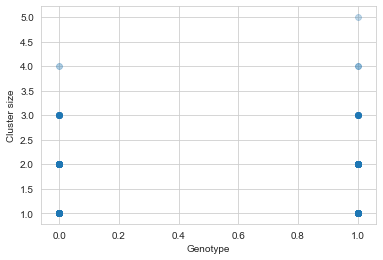

In [31]:
genotype = genome[0][:,200]
with sns.axes_style('whitegrid'):
    sns.scatterplot(y=cell_phenotypes, x=genotype, edgecolor=None, alpha=.1)
    plt.ylabel('Cluster size')
    plt.xlabel('Genotype')
    plt.show()
    plt.close()

This plot doesn't really tell us much. It just shows us the distribution of the data more or less. Although with how ordinal the data is its kinda hard to see densities.

In [32]:
genotype = genome[0][:,200].reshape(-1,1)

glm = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X=genotype, y=cell_phenotypes)

In [33]:

pred_pheno = glm.predict_proba(genotype)
alt = log_loss(y_true=cell_phenotypes, y_pred=pred_pheno, normalize=False)

In [34]:
#Generate the null hypothesis:
size_table = Counter(cell_phenotypes)

null_prob = np.zeros(shape=(len(cell_phenotypes), 5))
for _class in size_table.keys():
    null_prob[:,_class-1] = size_table[_class]/len(cell_phenotypes)


To do the likelihood ratio test of this model using this structure I have gleaned from some notes around the internet of implementations in python that I can use the log loss functions to get the log likelihood of the model. But I need to get the null hypothesis. I think that the null hypothesis would be to use the actual proportions seen in the phenotypic data.

e.g. In the binary classification case if I had a vector: [1,0,1,1,0]; then my null probablity for 0 and 1 respectively would be [2/5, 3/5] For each of the genotypes. I think this makes sense and I'll try it out

In [35]:
null = log_loss(y_true=cell_phenotypes, y_pred=null_prob, normalize=False)

In [36]:
#LRT
df = 1
G = -2 * (alt - null)
p_value = chi2.sf(G, df)

In [37]:
print(p_value)

0.06956249970303735


This seems to be giving some reasonable results. Although I am unsure as to what are the correct degrees of freedom for this test. I think I simply have 2 parameters in my alternate model and 1 parameter in my null model meaning that my LRT has 1 dof. Now let's go ahead and wrap it into a function and let it rip.

In [51]:
def multiN_LRT(genotype, phenotype, df=1):
    
    #reformat genotype data:
    genotype = genotype.reshape(-1,1)
    
    glm = LogisticRegression(penalty='none', solver='newton-cg', multi_class='multinomial').fit(X=genotype, y=phenotype)
    
    #Get log loss for alternate hypothesis
    pred_pheno = glm.predict_proba(genotype)
    alt_log_likelihood = log_loss(y_true=phenotype, y_pred=pred_pheno, normalize=False)
    
    #get log likelihood for null model:
    size_table = Counter(phenotype)

    null_prob = np.zeros(shape=(len(phenotype), max(phenotype)))
    for _class in size_table.keys():
        null_prob[:,_class-1] = size_table[_class]/len(phenotype)
    
    null_log_likelihood = log_loss(y_true=phenotype, y_pred=null_prob, normalize=False)
    
    L = -2 * (alt_log_likelihood - null_log_likelihood)
    p = chi2.sf(L, df)
    
    return p

def calc_P_val(chromosome, cell_phenotypes, coordinates, chrom_name):
    p_arr = []
    for position in range(chromosome.shape[1]):
        p = multiN_LRT(genotype=chromosome[:,position], phenotype=cell_phenotypes)
        p_arr.append(p)
    log_p = -np.log10(np.asarray(p_arr))
    bonferonni = -np.log10(0.05/len(coordinates))
    fig = plt.figure(figsize=(12.5,5))

    with sns.axes_style('whitegrid'):
        sns.scatterplot(x=coordinates, y=log_p, edgecolor=None, alpha=.25)
        plt.xlabel('Mb')
        plt.ylabel('-log10(p)')
        plt.axhline(bonferonni, linestyle='--',c='green')
        plt.title(chrom_name)
        plt.show()
        plt.close()
    return log_p

In [35]:
myAnalysis = sciAnalysis.analyzeSEQ()
myAnalysis.polarized_samples = myAnalysis.load_SNP_array(path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/',
                                                                snp_array='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_SZ_10_SD_0.npy', encoding='latin1')
myAnalysis.paintedGenome = [np.concatenate((myAnalysis.polarized_samples[0][0][:, 0], myAnalysis.polarized_samples[0][1][:, 0] + 23000000)) / 1000000,
                                    np.concatenate((myAnalysis.polarized_samples[0][2][:, 0], myAnalysis.polarized_samples[0][3][:, 0] + 24500000)) / 1000000,
                                    myAnalysis.polarized_samples[0][4][:, 0] / 1000000]

SNP input loaded... 2343 cells read in...


## MultiN regression results:

So, we can actually see that this kind of works. Chr2 and ChrX do not show any strong signatures of genotypes being associated with cluster size. But in Chr3 we see this much stronger association to cluster size that is linked with our centromere. Which is exactly what you would expect. The p-value doesn't break the bonferonni correction, but I think that's okay. The pattern is still there regardless and it seems to map this size dependent locus quite well. I'm going to test this out with other data sets to see if this is reproducible/not a fluke. 

# SZ locus mapping:

To verify my result of the MultiN regression I am going to perform the clustering and phenotypic analysis for different SD and SZ parameters.

## SZ 0 and SD 10:
For this test we expect no association seen in the Manhattan-esque plot.

In [49]:
def collect_genome(posteriors_file, TSV_file):
    
    data_path = '/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/'
    posteriors = np.load(os.path.join(data_path, posteriors_file))
    
    cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)
    CO, s_labels = readCO(tsv=TSV_file, 
                    path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/')
    pileups = getSNP_Vector(CO_data=CO,
                 state_labels=s_labels, 
                  numpy='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_SZ_10_SD_0.npy')

    table = cluster_table(cluster_pred)
    flat_clusters = [np.random.choice(cluster) for cluster in table.values() if len(cluster)] 

    #Join the SNP pileup structure
    genome = []
    for chrom in range(3):
        arm = []
        for cell in flat_clusters:
            if len(arm) == 0:
                arm = pileups[cell][chrom]
            else:
                arm = np.vstack((arm, pileups[cell][chrom]))
        genome.append(arm)


    #Get the "phenotypes" for each of the cells:
    phenotype_table = {}
    c_size = Counter(cluster_pred)
    for clust_key in table.keys():
        for cell in table[clust_key]:
            phenotype_table[cell] = c_size[clust_key]

    #Get the phenotype for only our cells of interest:
    cell_phenotypes = []
    for cell in flat_clusters:
        cell_phenotypes.append(phenotype_table[cell])
        
    return cell_phenotypes, genome

In [45]:
phenotypes, genotypes = collect_genome(posteriors_file='SPARSE_SZ_0_SD_10_HMM_posteriors.npy', TSV_file='SZ_0_SD_10_crossovers.tsv')

SNP input loaded... 2343 cells read in...


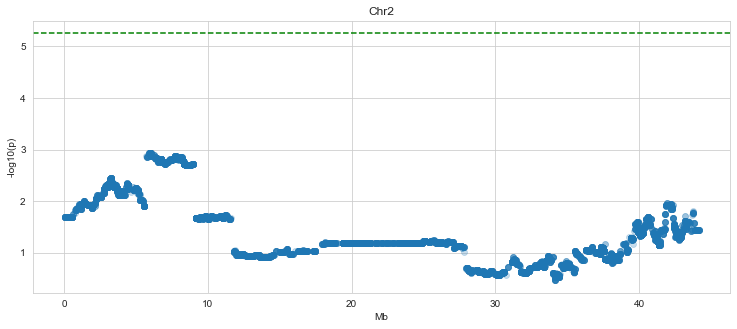

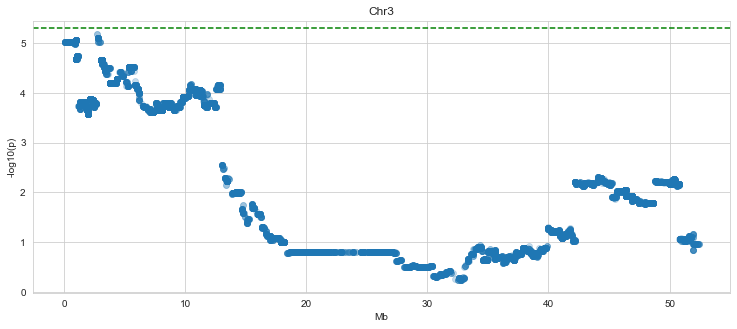

KeyboardInterrupt: 

In [52]:
#Run the LRT
chrom_names = ['Chr2', 'Chr3', 'ChrX']
for chrom in range(3):
    calc_P_val(chromosome=genotypes[chrom], chrom_name=chrom_names[chrom], 
               cell_phenotypes=phenotypes, coordinates=myAnalysis.paintedGenome[chrom])

This is about what you would expect, but there is some weirdness. The Chr3 centromere doesn't show association with cluster size, but for some reason the telomeric sequence does. I think this could just be due to over sampling of an individual that has a much greater body size and with a particular genotype on it's 2L arm.

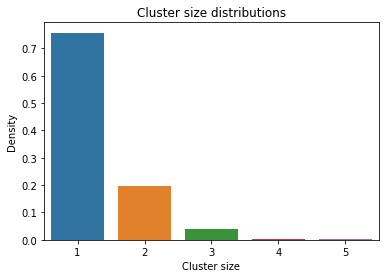

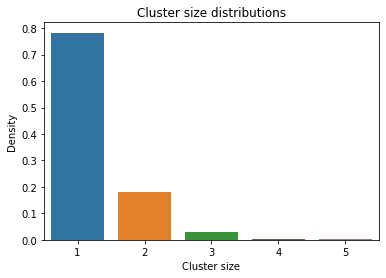

In [113]:
posteriors_file='SPARSE_SZ_0_SD_10_HMM_posteriors.npy'
TSV_file='SZ_0_SD_10_crossovers.tsv'
data_path = '/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/'
posteriors = np.load(os.path.join(data_path, posteriors_file))
    
cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)

#Get chr3 labels:
P1, P2 = labels(chromosome=1,cluster_pred=cluster_pred, dataframe='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SZ_0_SD_10_crossovers.tsv')
#P1 cluster sizes
P1_pi = get_cluster_sizes(P1)
plot_pi(P1_pi)

#P2 cluster sizes:
P2_pi = get_cluster_sizes(P2)
plot_pi(P2_pi)

Here we have the distribution of cluster sizes for P1/P1 and P1/P2. We see equal bias for the cluster distributions as is expected

In [114]:
CO_df = pd.read_csv(os.path.join(data_path, TSV_file), sep='\t', header=None)
true_labels = CO_df.values[:,0]

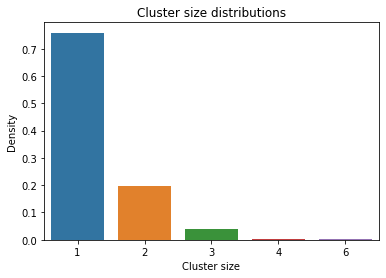

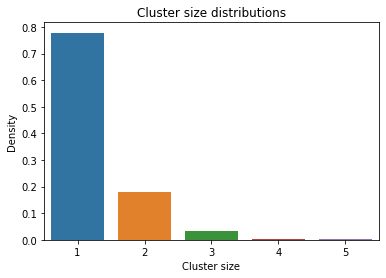

In [115]:
#Get chr3 labels:
P1, P2 = labels(chromosome=1,cluster_pred=true_labels, dataframe='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SZ_0_SD_10_crossovers.tsv')
#P1 cluster sizes
P1_pi = get_cluster_sizes(P1)
plot_pi(P1_pi)

#P2 cluster sizes:
P2_pi = get_cluster_sizes(P2)
plot_pi(P2_pi)

## SZ 50 SD 0:


In [53]:
phenotypes, genotypes = collect_genome(posteriors_file='SPARSE_SZ_50_SD_0_HMM_posteriors.npy', TSV_file='SZ_50_SD_0_crossovers.tsv')

#Run the LRT
chrom_names = ['Chr2', 'Chr3', 'ChrX']
for chrom in range(3):
    calc_P_val(chromosome=genotypes[chrom], chrom_name=chrom_names[chrom], 
               cell_phenotypes=phenotypes, coordinates=myAnalysis.paintedGenome[chrom])

SNP input loaded... 2343 cells read in...


ValueError: y_true and y_pred contain different number of classes 7, 8. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [1 2 3 4 5 6 8]

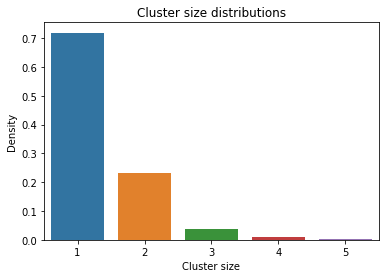

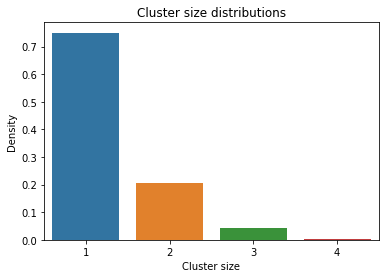

In [107]:
posteriors_file='SPARSE_SZ_50_SD_0_HMM_posteriors.npy'
TSV_file='SZ_50_SD_0_crossovers.tsv'

posteriors = np.load(os.path.join(data_path, posteriors_file))  
cluster_pred = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=20, affinity='euclidean', linkage='ward').fit_predict(posteriors)

#Get chr3 labels:
P1, P2 = labels(chromosome=1, cluster_pred=cluster_pred, dataframe=os.path.join('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/', TSV_file))
#P1 cluster sizes
P1_pi = get_cluster_sizes(P1)
plot_pi(P1_pi)

#P2 cluster sizes:
P2_pi = get_cluster_sizes(P2)
plot_pi(P2_pi)